# Imports and parameters

In [1]:
import os
from multiprocessing import Pool, cpu_count
from astropy.coordinates.sky_coordinate import SkyCoord
from astropy.cosmology import Planck15 as cosmo
import astropy.units as u
from astropy.wcs import WCS
import numpy as np
import scipy.ndimage as ndimage
import copy
import emcee
import corner
import matplotlib
import matplotlib.pyplot as plt
import healpy as hp
from matplotlib.colors import SymLogNorm

from PerseusGammaCalibration import persus_model_library
import minot

# Modify plotting parameters
dict_base = {'font.size':        16,
             'legend.fontsize':  16,
             'xtick.labelsize':  16,
             'ytick.labelsize':  16,
             'axes.labelsize':   16,
             'axes.titlesize':   16,
             'figure.titlesize': 16,    
             'figure.figsize':[8.0, 6.0],
             'figure.subplot.right':0.97,
             'figure.subplot.left':0.15,
             'font.family':'serif',
             'figure.facecolor': 'white',
             'legend.frameon': True}
plt.rcParams.update(dict_base)

In [2]:
outdir = os.getenv('CTAPHYS_OUT_DIR')+'Perseus_KSP_calibration'

# Define the models

In [3]:
cluster = persus_model_library.default_model()
cluster.Npt_per_decade_integ = 50

In [4]:
Clist = []

#---------- eta = 1, alpha = 2.3
ctmp = copy.deepcopy(cluster)
radius = np.logspace(0,5,100000)*u.kpc
r,n = ctmp.get_density_gas_profile(radius)
ctmp.density_crp_model = {'name':'User', 'radius':radius, 'profile':n.value**1.0}
ctmp.spectrum_crp_model = {'name':'PowerLaw', 'Index':2.3}
ctmp.name = r'$\eta_{\rm CRp}=1.0$, $\alpha_{\rm CRp}=2.3$'
Clist.append(ctmp)

#---------- eta = 0.5, alpha = 2.3
ctmp = copy.deepcopy(cluster)
radius = np.logspace(0,5,100000)*u.kpc
r,n = ctmp.get_density_gas_profile(radius)
ctmp.density_crp_model = {'name':'User', 'radius':radius, 'profile':n.value**0.5}
ctmp.spectrum_crp_model = {'name':'PowerLaw', 'Index':2.3}
ctmp.name = r'$\eta_{\rm CRp}=0.5$, $\alpha_{\rm CRp}=2.3$'
Clist.append(ctmp)

#---------- eta = 0.0, alpha = 2.3
ctmp = copy.deepcopy(cluster)
radius = np.logspace(0,5,100000)*u.kpc
r,n = ctmp.get_density_gas_profile(radius)
ctmp.density_crp_model = {'name':'User', 'radius':radius, 'profile':n.value**0.0}
ctmp.spectrum_crp_model = {'name':'PowerLaw', 'Index':2.3}
ctmp.name = r'$\eta_{\rm CRp}=0.0$, $\alpha_{\rm CRp}=2.3$'
Clist.append(ctmp)

#---------- eta = 1, alpha = 2.5
ctmp = copy.deepcopy(cluster)
ctmp.set_density_crp_isodens_scal_param(1.0)
ctmp.spectrum_crp_model = {'name':'PowerLaw', 'Index':2.5}
ctmp.name = r'$\eta_{\rm CRp}=1$, $\alpha_{\rm CRp}=2.5$'
Clist.append(ctmp)

#---------- eta = 1, alpha = 2.7
ctmp = copy.deepcopy(cluster)
ctmp.set_density_crp_isodens_scal_param(1.0)
ctmp.spectrum_crp_model = {'name':'PowerLaw', 'Index':2.7}
ctmp.name = r'$\eta_{\rm CRp}=1$, $\alpha_{\rm CRp}=2.7$'
Clist.append(ctmp)

# Gamma ray spectrum

/Users/adam/Project/anaconda3/envs/cta/lib/python2.7/site-packages/minot/model_modpar.py:1118: RuntimeWarning: divide by zero encountered in log10
  np.log10(user_p), kind='linear', fill_value='extrapolate')
/Users/adam/Project/anaconda3/envs/cta/lib/python2.7/site-packages/scipy/interpolate/interpolate.py:610: RuntimeWarning: invalid value encountered in subtract
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]


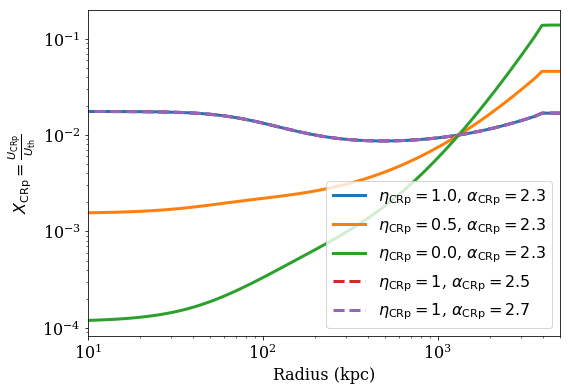

In [5]:
fig = plt.figure(0, figsize=(8, 6))
for i in [0,1,2]:
    r, x = Clist[i].get_crp_to_thermal_energy_profile()
    plt.loglog(r.to_value('kpc'), x, label=Clist[i].name, linewidth=3)
    
for i in [3,4]:
    r, x = Clist[i].get_crp_to_thermal_energy_profile()
    plt.loglog(r.to_value('kpc'), x, label=Clist[i].name, linestyle='--', linewidth=3)
    
plt.xlabel(r'Radius (kpc)')
plt.ylabel(r'$X_{\rm CRp} = \frac{U_{\rm CRp}}{U_{\rm th}}$')
plt.xlim(10,5e3)
plt.legend()

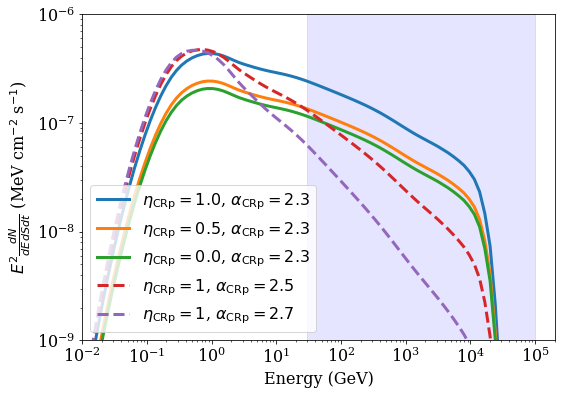

In [6]:
fig = plt.figure(0, figsize=(8, 6))
for i in [0,1,2]:
    e, s = Clist[i].get_gamma_spectrum(Rmax=Clist[i].R500, type_integral='cylindrical')
    plt.loglog(e.to_value('GeV'), (e*e*s).to_value('MeV s-1 cm-2'), label=Clist[i].name, linewidth=3)
    
for i in [3,4]:
    e, s = Clist[i].get_gamma_spectrum(Rmax=Clist[i].R500, type_integral='cylindrical')
    plt.loglog(e.to_value('GeV'), (e*e*s).to_value('MeV s-1 cm-2'), label=Clist[i].name, linestyle='--', linewidth=3)
    
plt.fill_between([30, 100e3], [0,0], [1e6,1e6], color='blue', alpha=0.1)
plt.xlabel(r'Energy (GeV)')
plt.ylabel(r'$E^2\frac{dN}{dEdSdt}$ (MeV cm$^{-2}$ s$^{-1}$)')
plt.xlim(1e-2, 2e5)
plt.ylim(1e-9, 1e-6)
plt.legend(loc='lower left')

# Gamma ray profile

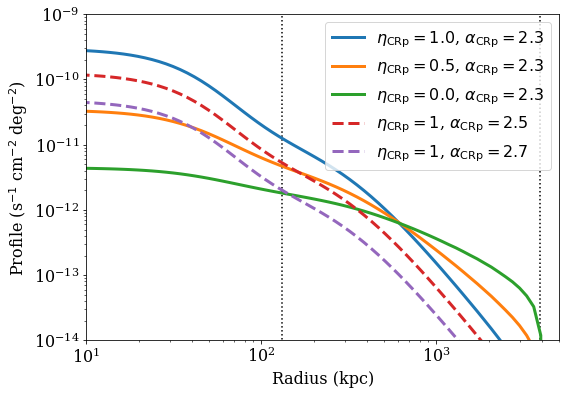

In [7]:
fig = plt.figure(0, figsize=(8, 6))
for i in [0,1,2]:
    r, p = Clist[i].get_gamma_profile(Emin=50*u.GeV, Emax=100*u.TeV)
    plt.loglog(r.to_value('kpc'), p.to_value('s-1 cm-2 deg-2'), label=Clist[i].name, linewidth=3)
    
for i in [3,4]:
    r, p = Clist[i].get_gamma_profile(Emin=50*u.GeV, Emax=100*u.TeV)
    plt.loglog(r.to_value('kpc'), p.to_value('s-1 cm-2 deg-2'), label=Clist[i].name, linestyle='--', linewidth=3)
plt.vlines((0.1*u.deg*cluster.cosmo.kpc_proper_per_arcmin(cluster.redshift)).to_value('kpc'), 0,1, linestyle=':', color='k')
plt.vlines((3*u.deg*cluster.cosmo.kpc_proper_per_arcmin(cluster.redshift)).to_value('kpc'), 0,1, linestyle=':', color='k')
plt.xlabel(r'Radius (kpc)')
plt.ylabel(r'Profile (s$^{-1}$ cm$^{-2}$ deg$^{-2}$)')
plt.xlim(10,5e3)
plt.ylim(1e-14,1e-9)
plt.legend()